In [16]:
import re
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from scipy import stats

# ---------------------------
# Parsing
# ---------------------------

def parse_results_file(path: str) -> Dict[str, Dict[str, Dict[str, float]]]:
    """
    Parse one results file.

    Returns:
      data[model][metric] = {'value': float, 'lo': float or None, 'hi': float or None}
    Skips entries with "Not found".
    """
    data: Dict[str, Dict[str, Dict[str, float]]] = {}
    current_model = None

    subject_re = re.compile(r'^\s*Subject:\s*(.+?)\s*$')
    line_re = re.compile(r'^\s{2,}(.+?):\s*(.+?)\s*$')
    num_ci_re = re.compile(
        r'^\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*\[\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*,\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*\]\s*$'
    )
    num_only_re = re.compile(r'^\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*$')

    with open(path, 'r', encoding='utf-8') as f:
        for raw in f:
            line = raw.rstrip('\n')

            m_sub = subject_re.match(line)
            if m_sub:
                current_model = m_sub.group(1).strip()
                if current_model not in data:
                    data[current_model] = {}
                continue

            m_line = line_re.match(line)
            if not m_line or current_model is None:
                continue

            metric = m_line.group(1).strip()
            val_str = m_line.group(2).strip()

            # Skip "Not found"
            if val_str.lower().startswith('not found'):
                continue

            m_num_ci = num_ci_re.match(val_str)
            if m_num_ci:
                v = float(m_num_ci.group(1))
                lo = float(m_num_ci.group(2))
                hi = float(m_num_ci.group(3))
                data[current_model][metric] = {'value': v, 'lo': lo, 'hi': hi}
                continue

            m_num = num_only_re.match(val_str)
            if m_num:
                v = float(m_num.group(1))
                data[current_model][metric] = {'value': v, 'lo': None, 'hi': None}
                continue

            # Unrecognized format; ignore
    return data


# ---------------------------
# Utilities
# ---------------------------

def is_correlation_metric(metric_name: str) -> bool:
    """Heuristic: treat metrics containing 'correl' (case-insensitive) as correlations."""
    return 'correl' in metric_name.lower()

def zcrit_from_level(level: float = 0.95) -> float:
    return stats.norm.ppf(0.5 + level/2.0)

def fisher_z(x: np.ndarray) -> np.ndarray:
    x = np.clip(x, -0.999999, 0.999999)
    return np.arctanh(x)

def inv_fisher_z(z: np.ndarray) -> np.ndarray:
    return np.tanh(z)

def se_from_ci(lo: np.ndarray, hi: np.ndarray, level: float = 0.95) -> np.ndarray:
    zcrit = zcrit_from_level(level)
    return (hi - lo) / (2.0 * zcrit)

def se_from_ci_fisher_r(lo_r: np.ndarray, hi_r: np.ndarray, level: float = 0.95) -> np.ndarray:
    zcrit = zcrit_from_level(level)
    lo_z = fisher_z(lo_r)
    hi_z = fisher_z(hi_r)
    return (hi_z - lo_z) / (2.0 * zcrit)

def fixed_effect_pool(values: np.ndarray, se: np.ndarray) -> Tuple[float, float, float]:
    """Inverse-variance weighted mean and its SE and CI bounds (on the same scale as values)."""
    w = 1.0 / (se**2)
    mu = np.sum(w * values) / np.sum(w)
    se_mu = 1.0 / np.sqrt(np.sum(w))
    return mu, se_mu, w.sum()

def mean_t_ci(x: np.ndarray, level: float = 0.95) -> Tuple[float, float, float]:
    """Mean, SE, and t critical for a sample (across models)."""
    k = x.size
    m = x.mean()
    sd = x.std(ddof=1) if k > 1 else 0.0
    se = sd / np.sqrt(k) if k > 0 else np.nan
    tcrit = stats.t.ppf(0.5 + level/2.0, df=max(k-1, 1))
    return m, se, tcrit


# ---------------------------
# Collect per-metric data
# ---------------------------

def collect_metric_data(metric: str, file_paths: List[str]) -> Dict[str, pd.DataFrame]:
    """
    For each file, return a DataFrame with columns:
      model, value, lo, hi, has_ci (bool)
    Only includes models that have the metric present.
    """
    out = {}
    metric_lower = metric.lower()
    for path in file_paths:
        parsed = parse_results_file(path)
        rows = []
        for model, metrics in parsed.items():
            # case-insensitive lookup across keys
            match_key = None
            for k in metrics.keys():
                if k.lower() == metric_lower:
                    match_key = k
                    break
            if match_key is None:
                continue
            entry = metrics[match_key]
            v = entry.get('value', None)
            lo = entry.get('lo', None)
            hi = entry.get('hi', None)
            if v is None:
                continue
            has_ci = lo is not None and hi is not None
            rows.append({'model': model, 'value': float(v),
                         'lo': float(lo) if has_ci else np.nan,
                         'hi': float(hi) if has_ci else np.nan,
                         'has_ci': has_ci})
        df = pd.DataFrame(rows)
        out[path] = df.sort_values('model').reset_index(drop=True)
    return out


# ---------------------------
# Per-file summaries
# ---------------------------

def summarize_per_file(metric: str,
                       file_to_df: Dict[str, pd.DataFrame],
                       ci_level: float = 0.95) -> pd.DataFrame:
    """
    For each file, compute an overall mean and CI:
      - If per-model CIs exist: fixed-effect inverse-variance pooling.
        * If correlation metric: operate on Fisher z and back-transform for reporting.
        * Else: operate on raw scale.
      - If no per-model CIs: mean±t across models.
    Returns a DataFrame with columns:
      file, n_models, method, mean, ci_lo, ci_hi
    """
    is_corr = is_correlation_metric(metric)
    zcrit = zcrit_from_level(ci_level)

    rows = []
    for path, df in file_to_df.items():
        n = len(df)
        if n == 0:
            rows.append({'file': path, 'n_models': 0, 'method': 'no data',
                         'mean': np.nan, 'ci_lo': np.nan, 'ci_hi': np.nan})
            continue

        has_any_ci = df['has_ci'].any()
        if has_any_ci:
            # Use only models with CIs
            d = df[df['has_ci']].copy()
            if len(d) == 0:
                rows.append({'file': path, 'n_models': 0, 'method': 'no usable CI',
                             'mean': np.nan, 'ci_lo': np.nan, 'ci_hi': np.nan})
                continue

            if is_corr:
                # Pool on Fisher z
                vals_z = fisher_z(d['value'].to_numpy())
                se_z = se_from_ci_fisher_r(d['lo'].to_numpy(), d['hi'].to_numpy(), level=ci_level)
                se_z, used_floor = stabilize_se(se_z, fallback='floor')
                z_bar, se_bar, _ = fixed_effect_pool(vals_z, se_z)
                ci_z = (z_bar - zcrit*se_bar, z_bar + zcrit*se_bar)
                mean_r = float(inv_fisher_z(np.array([z_bar]))[0])
                ci_lo = float(inv_fisher_z(np.array([ci_z[0]]))[0])
                ci_hi = float(inv_fisher_z(np.array([ci_z[1]]))[0])
                method = 'fixed-effect IVW on Fisher z'
                rows.append({'file': path, 'n_models': int(len(d)), 'method': method,
                             'mean': mean_r, 'ci_lo': ci_lo, 'ci_hi': ci_hi})
            else:
                # Pool on raw scale
                vals = d['value'].to_numpy()
                se = se_from_ci(d['lo'].to_numpy(), d['hi'].to_numpy(), level=ci_level)
                se, used_floor = stabilize_se(se, fallback='floor')
                mu, se_mu, _ = fixed_effect_pool(vals, se)
                ci = (mu - zcrit*se_mu, mu + zcrit*se_mu)
                method = 'fixed-effect IVW (raw scale)'
                rows.append({'file': path, 'n_models': int(len(d)), 'method': method,
                             'mean': float(mu), 'ci_lo': float(ci[0]), 'ci_hi': float(ci[1])})
        else:
            # No per-model CIs -> mean±t across models
            vals = df['value'].to_numpy()
            m, se, tcrit = mean_t_ci(vals, level=ci_level)
            ci = (m - tcrit*se, m + tcrit*se) if len(vals) > 1 else (m, m)
            method = 'mean±t across models (no model CIs)'
            rows.append({'file': path, 'n_models': int(len(vals)), 'method': method,
                         'mean': float(m), 'ci_lo': float(ci[0]), 'ci_hi': float(ci[1])})

    summary = pd.DataFrame(rows)
    return summary


# ---------------------------
# Pairwise comparisons
# ---------------------------

def pairwise_comparisons(metric: str,
                         file_to_df: Dict[str, pd.DataFrame],
                         ci_level: float = 0.95,
                         assume_independent: bool = True) -> pd.DataFrame:
    """
    For each file pair:
      - Identify overlapping models with data for the metric in both.
      - If both sides have per-model CIs for the overlaps:
          * If correlation metric: paired IVW difference on Fisher z.
          * Else: paired IVW difference on raw scale.
      - Else (no CIs): paired t-test across models (raw differences).

    Returns DataFrame with:
      file1, file2, n_common, same_model_set, method, est, ci_lo, ci_hi, p_value
    est/CI are on:
      - Fisher z scale for correlation metrics (paired IVW),
      - raw scale otherwise,
      - raw scale difference for paired t.
    """
    is_corr = is_correlation_metric(metric)
    zcrit = zcrit_from_level(ci_level)
    files = list(file_to_df.keys())

    # Precompute model sets for equality check
    models_per_file = {f: set(file_to_df[f]['model']) for f in files}

    records = []

    for i in range(len(files)):
        for j in range(i+1, len(files)):
            f1, f2 = files[i], files[j]
            d1 = file_to_df[f1]
            d2 = file_to_df[f2]
            overlap = sorted(set(d1['model']).intersection(set(d2['model'])))

            same_set = models_per_file[f1] == models_per_file[f2]
            if len(overlap) == 0:
                records.append({'file1': f1, 'file2': f2, 'n_common': 0, 'same_model_set': same_set,
                                'method': 'no overlap', 'est': np.nan, 'ci_lo': np.nan,
                                'ci_hi': np.nan, 'p_value': np.nan})
                continue

            # Join on model
            j1 = d1.set_index('model').loc[overlap]
            j2 = d2.set_index('model').loc[overlap]

            # Identify if we can do IVW (need CIs on both)
            use_ivw = j1['has_ci'].all() and j2['has_ci'].all()

            if use_ivw:
                if is_corr:
                    # Work on Fisher z
                    v1 = fisher_z(j1['value'].to_numpy())
                    v2 = fisher_z(j2['value'].to_numpy())
                    se1 = se_from_ci_fisher_r(j1['lo'].to_numpy(), j1['hi'].to_numpy(), level=ci_level)
                    se2 = se_from_ci_fisher_r(j2['lo'].to_numpy(), j2['hi'].to_numpy(), level=ci_level)
                    # Independence assumption -> Var(d) = se1^2 + se2^2
                    var_d = se1**2 + se2**2 if assume_independent else se1**2 + se2**2
                    d = v2 - v1
                    w = 1.0 / var_d
                    D = np.sum(w * d) / np.sum(w)
                    SE_D = 1.0 / np.sqrt(np.sum(w))
                    ci = (D - zcrit*SE_D, D + zcrit*SE_D)
                    z_stat = D / SE_D
                    p = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))
                    method = 'paired IVW on Fisher z'
                    records.append({'file1': f1, 'file2': f2, 'n_common': len(overlap),
                                    'same_model_set': same_set, 'method': method,
                                    'est': float(D), 'ci_lo': float(ci[0]),
                                    'ci_hi': float(ci[1]), 'p_value': float(p)})
                else:
                    # Raw scale IVW
                    v1 = j1['value'].to_numpy()
                    v2 = j2['value'].to_numpy()
                    se1 = se_from_ci(j1['lo'].to_numpy(), j1['hi'].to_numpy(), level=ci_level)
                    se2 = se_from_ci(j2['lo'].to_numpy(), j2['hi'].to_numpy(), level=ci_level)
                    var_d = se1**2 + se2**2 if assume_independent else se1**2 + se2**2
                    d = v2 - v1
                    w = 1.0 / var_d
                    D = np.sum(w * d) / np.sum(w)
                    SE_D = 1.0 / np.sqrt(np.sum(w))
                    ci = (D - zcrit*SE_D, D + zcrit*SE_D)
                    z_stat = D / SE_D
                    p = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))
                    method = 'paired IVW (raw scale)'
                    records.append({'file1': f1, 'file2': f2, 'n_common': len(overlap),
                                    'same_model_set': same_set, 'method': method,
                                    'est': float(D), 'ci_lo': float(ci[0]),
                                    'ci_hi': float(ci[1]), 'p_value': float(p)})
            else:
                # Paired t on raw differences across models
                # Use only models with values (ignore CI fields)
                v1 = j1['value'].to_numpy()
                v2 = j2['value'].to_numpy()
                d = v2 - v1
                k = d.size
                Dbar = d.mean()
                sd = d.std(ddof=1) if k > 1 else 0.0
                se = sd / np.sqrt(k) if k > 0 else np.nan
                tcrit = stats.t.ppf(0.5 + ci_level/2.0, df=max(k-1, 1))
                ci = (Dbar - tcrit*se, Dbar + tcrit*se) if k > 1 else (Dbar, Dbar)
                t_stat = Dbar / se if se > 0 else np.inf * np.sign(Dbar)
                p = 2.0 * (1.0 - stats.t.cdf(abs(t_stat), df=max(k-1, 1))) if k > 1 else 0.0
                method = 'paired t across models (no model CIs)'
                records.append({'file1': f1, 'file2': f2, 'n_common': int(k),
                                'same_model_set': same_set, 'method': method,
                                'est': float(Dbar), 'ci_lo': float(ci[0]),
                                'ci_hi': float(ci[1]), 'p_value': float(p)})

    return pd.DataFrame.from_records(records)


# ---------------------------
# Main entry point
# ---------------------------

def analyze_metric_across_files(metric_name: str,
                                file_paths: List[str],
                                ci_level: float = 0.95,
                                assume_independent: bool = True):
    """
    High-level function:
      - Parses files
      - Builds per-file summaries
      - Builds pairwise comparison table

    Returns (summary_df, pairwise_df)
    Also prints both tables.
    """
    file_to_df = collect_metric_data(metric_name, file_paths)

    # Per-file summaries
    summary = summarize_per_file(metric_name, file_to_df, ci_level=ci_level)

    # Pairwise comparisons
    pairwise = pairwise_comparisons(metric_name, file_to_df,
                                    ci_level=ci_level,
                                    assume_independent=assume_independent)

    # Pretty print
    pd.set_option('display.max_colwidth', 120)
    print(f"\nMetric: {metric_name}")
    print("\nPer-file summaries:")
    display(summary)

    print("\nPairwise comparisons:")
    display(pairwise)

    return summary, pairwise

def difference_of_pooled_test(summary_df: pd.DataFrame, ci_level: float = 0.95) -> pd.DataFrame:
    """
    For each file pair in a summary table (from summarize_per_file), test the
    difference between pooled means using their pooled SEs.

    Returns: file1, file2, est, ci_lo, ci_hi, p_value
    """
    zcrit = zcrit_from_level(ci_level)
    rows = []
    for i in range(len(summary_df)):
        for j in range(i+1, len(summary_df)):
            a = summary_df.iloc[i]
            b = summary_df.iloc[j]
            m1, m2 = float(a['mean']), float(b['mean'])
            se1 = (float(a['ci_hi']) - m1) / zcrit
            se2 = (float(b['ci_hi']) - m2) / zcrit
            diff = m1 - m2
            se = np.sqrt(se1**2 + se2**2)
            ci = (diff - zcrit*se, diff + zcrit*se)
            z_stat = diff / se if se > 0 else np.inf * np.sign(diff)
            p = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))
            rows.append({'file1': a['file'], 'file2': b['file'],
                         'est': diff, 'ci_lo': ci[0], 'ci_hi': ci[1], 'p_value': p})
    return pd.DataFrame(rows)

def stabilize_se(se: np.ndarray, fallback: str = 'floor') -> Tuple[np.ndarray, bool]:
    """
    Replace nonpositive or nonfinite SEs.
    fallback:
      - 'floor': set to 0.5 * min positive SE (or 1e-12 if none).
      - 'drop': return SEs and a flag indicating there were bad SEs (caller can drop rows).
    Returns (se_fixed, used_floor)
    """
    se = np.asarray(se, float)
    pos = np.isfinite(se) & (se > 0)
    if pos.any():
        floor = max(1e-12, 0.5 * float(np.min(se[pos])))
        bad = ~pos
        if fallback == 'floor':
            se[bad] = floor
            return se, True if bad.any() else False
        elif fallback == 'drop':
            return se, bad.any()
    else:
        # No positive SEs at all
        if fallback == 'floor':
            se[:] = 1e-12
            return se, True
        elif fallback == 'drop':
            return se, True
    return se, False

In [106]:
files = ["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt"]

metrics = [
    "Delegation rate",
#    "Naive Confidence",
    "Teammate-weighted confidence",
    "Raw introspection score",
    "Raw self-acc lift",
    "Team Accuracy Lift",
    #"Correctness Coef Cntl",
    "Correctness Correl Cntl",
    "Capent Correl Cntl",            # treated as correlation (Fisher z)
    "Capent Correl Prob Cntl",       # treated as correlation (Fisher z)
    "Calibration AUC",
    "ECE",
    #"Brier",
    #"Brier Resolution",
    #"Brier Reliability",
    #"Top Prob Mean",
    "Pseudo R2 Cntl",                # no CIs -> paired t
    "Game-Stated Entropy Diff",
    "Game-Stated Confounds Diff",
]

for m in metrics:
    summarize, compare = analyze_metric_across_files(m, files, ci_level=0.95, assume_independent=True)


Metric: Delegation rate

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.382429,0.250559,0.514299
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.539518,0.383375,0.695661
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.502676,0.346878,0.658474
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.674147,0.539893,0.808401



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.157088,0.041916,0.272260,0.010628
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.120247,-0.006210,0.246704,0.060933
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.291718,0.159707,0.423728,0.000249
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),-0.036841,-0.203892,0.130210,0.646431
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.134629,-0.013231,0.282490,0.071503
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.171471,0.052312,0.290629,0.007630



Metric: Teammate-weighted confidence

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.051954,0.045048,0.058860
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),-0.030341,-0.037577,-0.023105
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.128082,0.121280,0.134884
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.037187,0.030334,0.044040



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.109234,-0.119667,-0.098800,0.000000e+00
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.089469,0.079539,0.099400,0.000000e+00
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.037418,-0.047689,-0.027147,9.310330e-13
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.181458,0.171260,0.191656,0.000000e+00
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.068798,0.058432,0.079165,0.000000e+00
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.114776,-0.124794,-0.104757,0.000000e+00



Metric: Raw introspection score

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.136591,0.113824,0.159359
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.114631,0.092704,0.136557
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.141137,0.118543,0.163731
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.135700,0.110215,0.161186



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.024254,-0.055995,0.007487,0.134222
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.008563,-0.024005,0.041130,0.606341
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.003370,-0.031642,0.038383,0.850356
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.030018,-0.001998,0.062034,0.066114
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.031690,-0.002771,0.066151,0.071488
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.005393,-0.040002,0.029217,0.760067



Metric: Raw self-acc lift

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.083995,0.055838,0.112152
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.053154,0.022774,0.083534
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.017394,-0.000225,0.035012
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),0.046353,0.024531,0.068176



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.006301,-0.037139,0.049741,0.776191
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.051546,-0.086394,-0.016699,0.003741
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.019764,-0.021501,0.061028,0.347876
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.043439,-0.081384,-0.005493,0.024851
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.013460,-0.029449,0.056369,0.538676
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.052669,0.021981,0.083358,0.000769



Metric: Team Accuracy Lift

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),-0.084297,-0.095791,-0.072803
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),-0.111666,-0.122176,-0.101157
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),-0.130620,-0.140579,-0.120662
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,fixed-effect IVW (raw scale),-0.095932,-0.106282,-0.085582



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.016627,-0.032331,-0.000923,3.797002e-02
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.069619,-0.085124,-0.054115,0.000000e+00
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.009355,-0.025265,0.006555,2.491208e-01
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),-0.042589,-0.057295,-0.027884,1.375670e-08
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.014802,-0.000291,0.029895,5.458531e-02
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,17,True,paired IVW (raw scale),0.049939,0.035349,0.064529,1.962253e-11



Metric: Correctness Correl Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,fixed-effect IVW on Fisher z,0.109450,0.085467,0.133306
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,fixed-effect IVW on Fisher z,0.106974,0.084404,0.129435
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,16,fixed-effect IVW on Fisher z,0.134604,0.109737,0.159303
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,16,fixed-effect IVW on Fisher z,0.134911,0.110415,0.159244



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired IVW on Fisher z,-0.002523,-0.035769,0.030723,0.881756
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,16,False,paired IVW on Fisher z,0.023595,-0.011910,0.059100,0.192750
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,16,False,paired IVW on Fisher z,0.023106,-0.012598,0.058811,0.204647
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,16,False,paired IVW on Fisher z,0.028771,-0.005718,0.063260,0.102046
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,16,False,paired IVW on Fisher z,0.031651,-0.002996,0.066298,0.073380
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,16,True,paired IVW on Fisher z,0.001979,-0.033894,0.037851,0.913916



Metric: Capent Correl Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,12,fixed-effect IVW on Fisher z,0.212183,0.184445,0.239583
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,12,fixed-effect IVW on Fisher z,0.232260,0.206436,0.257760
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,fixed-effect IVW on Fisher z,0.084758,0.049377,0.119926
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,9,fixed-effect IVW on Fisher z,0.024650,-0.013983,0.063210



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,12,True,paired IVW on Fisher z,0.020517,-0.019106,0.060140,3.101547e-01
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired IVW on Fisher z,-0.103607,-0.151629,-0.055585,2.351637e-05
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,9,False,paired IVW on Fisher z,-0.137193,-0.191102,-0.083285,6.102330e-07
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired IVW on Fisher z,-0.134842,-0.181579,-0.088105,1.560783e-08
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,9,False,paired IVW on Fisher z,-0.195377,-0.247775,-0.142979,2.708944e-13
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,9,False,paired IVW on Fisher z,-0.072064,-0.130357,-0.013771,1.539327e-02



Metric: Capent Correl Prob Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,10,fixed-effect IVW on Fisher z,0.198771,0.168182,0.228976
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,fixed-effect IVW on Fisher z,0.239310,0.211075,0.267145
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,fixed-effect IVW on Fisher z,0.116767,0.076318,0.156832
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,fixed-effect IVW on Fisher z,0.036956,-0.004958,0.078741



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,True,paired IVW on Fisher z,0.041599,-0.001842,0.085039,6.053602e-02
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW on Fisher z,-0.062946,-0.117497,-0.008395,2.372190e-02
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW on Fisher z,-0.148015,-0.206378,-0.089653,6.670039e-07
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW on Fisher z,-0.124396,-0.177516,-0.071275,4.437535e-06
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW on Fisher z,-0.215424,-0.272150,-0.158698,9.836576e-14
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,True,paired IVW on Fisher z,-0.084892,-0.148701,-0.021082,9.120008e-03



Metric: Calibration AUC

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,12,fixed-effect IVW (raw scale),0.652993,0.637285,0.668701
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,12,fixed-effect IVW (raw scale),0.631829,0.617419,0.646238
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.541314,0.524590,0.558038
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.502887,0.500896,0.504878



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,12,True,paired IVW (raw scale),-0.017638,-0.038980,0.003703,1.052599e-01
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),-0.090607,-0.117484,-0.063730,3.913092e-11
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),0.000363,-0.024826,0.025552,9.774846e-01
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),-0.072024,-0.097751,-0.046296,4.092810e-08
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),0.012051,-0.011945,0.036047,3.249781e-01
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,True,paired IVW (raw scale),0.043822,0.024436,0.063207,9.396525e-06



Metric: ECE

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,12,fixed-effect IVW (raw scale),0.373953,0.360342,0.387565
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,12,fixed-effect IVW (raw scale),0.348562,0.335975,0.361150
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.714061,0.701602,0.726519
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.695604,0.683093,0.708114



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,12,True,paired IVW (raw scale),-0.021746,-0.040306,-0.003187,0.021646
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),0.329666,0.309921,0.349411,0.000000
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),0.296731,0.276466,0.316996,0.000000
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),0.345618,0.326568,0.364668,0.000000
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,False,paired IVW (raw scale),0.298522,0.278911,0.318132,0.000000
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,10,True,paired IVW (raw scale),-0.035438,-0.053577,-0.017299,0.000129



Metric: Pseudo R2 Cntl

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.088306,0.071108,0.105503
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,mean±t across models (no model CIs),0.102747,0.066729,0.138765
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,16,mean±t across models (no model CIs),0.096488,0.061652,0.131323
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,16,mean±t across models (no model CIs),0.134600,0.087581,0.181619



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,17,True,paired t across models (no model CIs),0.014441,-0.015893,0.044776,0.327892
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,16,False,paired t across models (no model CIs),0.009656,-0.031871,0.051183,0.627342
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,16,False,paired t across models (no model CIs),0.047769,0.006362,0.089176,0.026572
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,16,False,paired t across models (no model CIs),-0.009194,-0.062087,0.043700,0.716203
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,16,False,paired t across models (no model CIs),0.028919,-0.012698,0.070535,0.159274
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,16,True,paired t across models (no model CIs),0.038113,-0.020918,0.097143,0.188971



Metric: Game-Stated Entropy Diff

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.099927,0.062113,0.137741
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),0.046617,0.014459,0.078774
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),0.066440,0.011810,0.121069
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),-0.036515,-0.084045,0.011015



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,True,paired IVW (raw scale),-0.031100,-0.083887,0.021686,0.248189
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.079055,-0.149628,-0.008481,0.028127
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.127083,-0.194641,-0.059526,0.000227
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.030889,-0.102778,0.040999,0.399693
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.133010,-0.199766,-0.066254,0.000094
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,True,paired IVW (raw scale),-0.082819,-0.163046,-0.002593,0.043042



Metric: Game-Stated Confounds Diff

Per-file summaries:


,file,n_models,method,mean,ci_lo,ci_hi
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),-0.119971,-0.145787,-0.094155
1,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,fixed-effect IVW (raw scale),-0.053878,-0.077508,-0.030248
2,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),-0.114674,-0.139717,-0.089632
3,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,fixed-effect IVW (raw scale),-0.057668,-0.098580,-0.016756



Pairwise comparisons:


,file1,file2,n_common,same_model_set,method,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,10,True,paired IVW (raw scale),0.053190,0.017167,0.089213,0.003804
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.019035,-0.056779,0.018708,0.322916
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),0.048578,-0.005173,0.102330,0.076504
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.061418,-0.097474,-0.025362,0.000842
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,False,paired IVW (raw scale),-0.028478,-0.078313,0.021357,0.262706
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,8,True,paired IVW (raw scale),0.020970,-0.032081,0.074021,0.438491


In [12]:
difference_of_pooled_test(summarize)

,file1,file2,est,ci_lo,ci_hi,p_value
0,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,-0.184519,-0.900196,0.531158,0.613329
1,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,-0.631790,-1.347469,0.083888,0.083589
2,analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,-0.923882,-1.639558,-0.208206,0.011401
3,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,-0.447271,-1.162951,0.268408,0.220613
4,analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,-0.739363,-1.455040,-0.023685,0.042885
5,analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt,analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt,-0.292091,-1.007770,0.423587,0.423755


In [43]:
import os
from typing import List, Optional, Dict, Tuple
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

# Assumes parse_results_file(path) is already defined and returns:
# data[model][metric] = {'value': float, 'lo': float|None, 'hi': float|None}

def plot_metric_bars(
    metric: str,
    files: List[str],
    series_names: Optional[List[str]] = None,
    model_order: Optional[List[str]] = None,
    aliases: Optional[Dict[str, str]] = None,
    title: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    outfile: Optional[str] = None,
    figsize: Tuple[int, int] = (12, 6),
    dpi: int = 150,
    show_errorbars: bool = True,
    capsize: float = 3.0,
    ecolor: Optional[str] = None,  # None = matplotlib default
    elinewidth: float = 1.0,
    alpha_err: float = 0.7,
    chance: Optional[float] = None,
) -> Tuple[plt.Figure, plt.Axes, pd.DataFrame]:
    """
    Grouped bar chart for a metric across results files parsed by parse_results_file.

    - X-axis: models
    - Bars: one per file (series), ordered as in `files`
    - Optional:
        - series_names: legend labels (must match len(files))
        - model_order: explicit model order; others appended
        - aliases: {original_model_name: alias} for tick labels
        - title/xlabel/ylabel/outfile: labels and save path
        - show_errorbars: plot asymmetric CI if available (lo/hi)
    Returns:
        fig, ax, wide_values (DataFrame indexed by model, columns=series)
    """
    if not files:
        raise ValueError("files must be non-empty")
    if series_names is None:
        series_names = [os.path.basename(f) for f in files]
    if len(series_names) != len(files):
        raise ValueError("series_names length must match files")

    # Parse with your exact parser
    per_file = []
    all_models = set()
    for f in files:
        d = parse_results_file(f)
        per_file.append((f, d))
        all_models.update(d.keys())

    # Determine model ordering
    if model_order:
        models = [m for m in model_order if m in all_models] + [m for m in sorted(all_models) if m not in model_order]
    else:
        models = sorted(all_models)

    # Helper to pick metric (exact, then case-insensitive)
    def get_metric_entry(model_metrics: Dict[str, Dict[str, float]], name: str):
        if name in model_metrics:
            return model_metrics[name]
        lower_map = {k.lower(): k for k in model_metrics.keys()}
        k = lower_map.get(name.lower())
        return model_metrics.get(k, None) if k else None

    # Build wide tables: value, lo, hi
    wide_val = pd.DataFrame(index=models, columns=series_names, dtype=float)
    wide_lo  = pd.DataFrame(index=models, columns=series_names, dtype=float)
    wide_hi  = pd.DataFrame(index=models, columns=series_names, dtype=float)

    for (f, data), label in zip(per_file, series_names):
        for m in models:
            v = lo = hi = np.nan
            if m in data:
                entry = get_metric_entry(data[m], metric)
                if entry is not None:
                    v = entry.get("value", np.nan)
                    lo = entry.get("lo", np.nan)
                    hi = entry.get("hi", np.nan)
            wide_val.loc[m, label] = v
            wide_lo.loc[m, label] = lo
            wide_hi.loc[m, label] = hi

    # Drop models with no data for this metric across all series
    keep = wide_val.notna().any(axis=1) #wide_val.notna().all(axis=1)
    wide_val = wide_val.loc[keep]
    wide_lo  = wide_lo.loc[keep]
    wide_hi  = wide_hi.loc[keep]
    models = list(wide_val.index)  # keep order in the filtered table

    # Plot grouped bars
    n_models = len(models)
    n_series = len(series_names)
    x = np.arange(n_models)
    width = min(0.8 / max(n_series, 1), 0.22)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    for i, col in enumerate(series_names):
        vals = wide_val[col].to_numpy(dtype=float)
        pos = x - (n_series - 1) * width / 2 + i * width

        kwargs = {}
        if show_errorbars:
            lo = wide_lo[col].to_numpy(dtype=float)
            hi = wide_hi[col].to_numpy(dtype=float)

            # Compute asymmetric error lengths; mask where missing/invalid
            lower = vals - lo
            upper = hi - vals

            # Invalid if any NaN or negative (guard against rounding issues)
            invalid = np.isnan(lower) | np.isnan(upper) | (lower < 0) | (upper < 0)
            lower = np.where(invalid, np.nan, lower)
            upper = np.where(invalid, np.nan, upper)

            yerr = np.vstack([lower, upper])
            yerr = ma.array(yerr, mask=np.isnan(yerr))

            if (~yerr.mask).any():
                kwargs.update(dict(
                    yerr=yerr,
                    capsize=capsize,
                    error_kw=dict(elinewidth=elinewidth, alpha=alpha_err, ecolor=ecolor),
                ))
            # else: no valid errorbars in this series; skip

        ax.bar(pos, vals, width, label=col, **kwargs)

    # X tick labels (aliases)
    xlabels = [aliases.get(m, m) for m in models] if aliases else models
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=45, ha="right")

    ax.set_xlabel(xlabel or "Model")
    ax.set_ylabel(ylabel or metric)
    if title:
        ax.set_title(title)
    ax.legend(title="Series")
    ax.grid(axis="y", linestyle=":", alpha=0.35)
    if chance is not None:
        ax.axhline(chance, linestyle="--", color="0.4", linewidth=1.2, zorder=0)
    fig.tight_layout()

    # Save and show
    if outfile is None:
        safe_metric = "".join(ch if ch.isalnum() or ch in ("_", "-") else "_" for ch in metric)
        outfile = f"{safe_metric}_bars.png"
    fig.savefig(outfile, bbox_inches="tight")
    plt.show()

    return fig, ax, wide_val

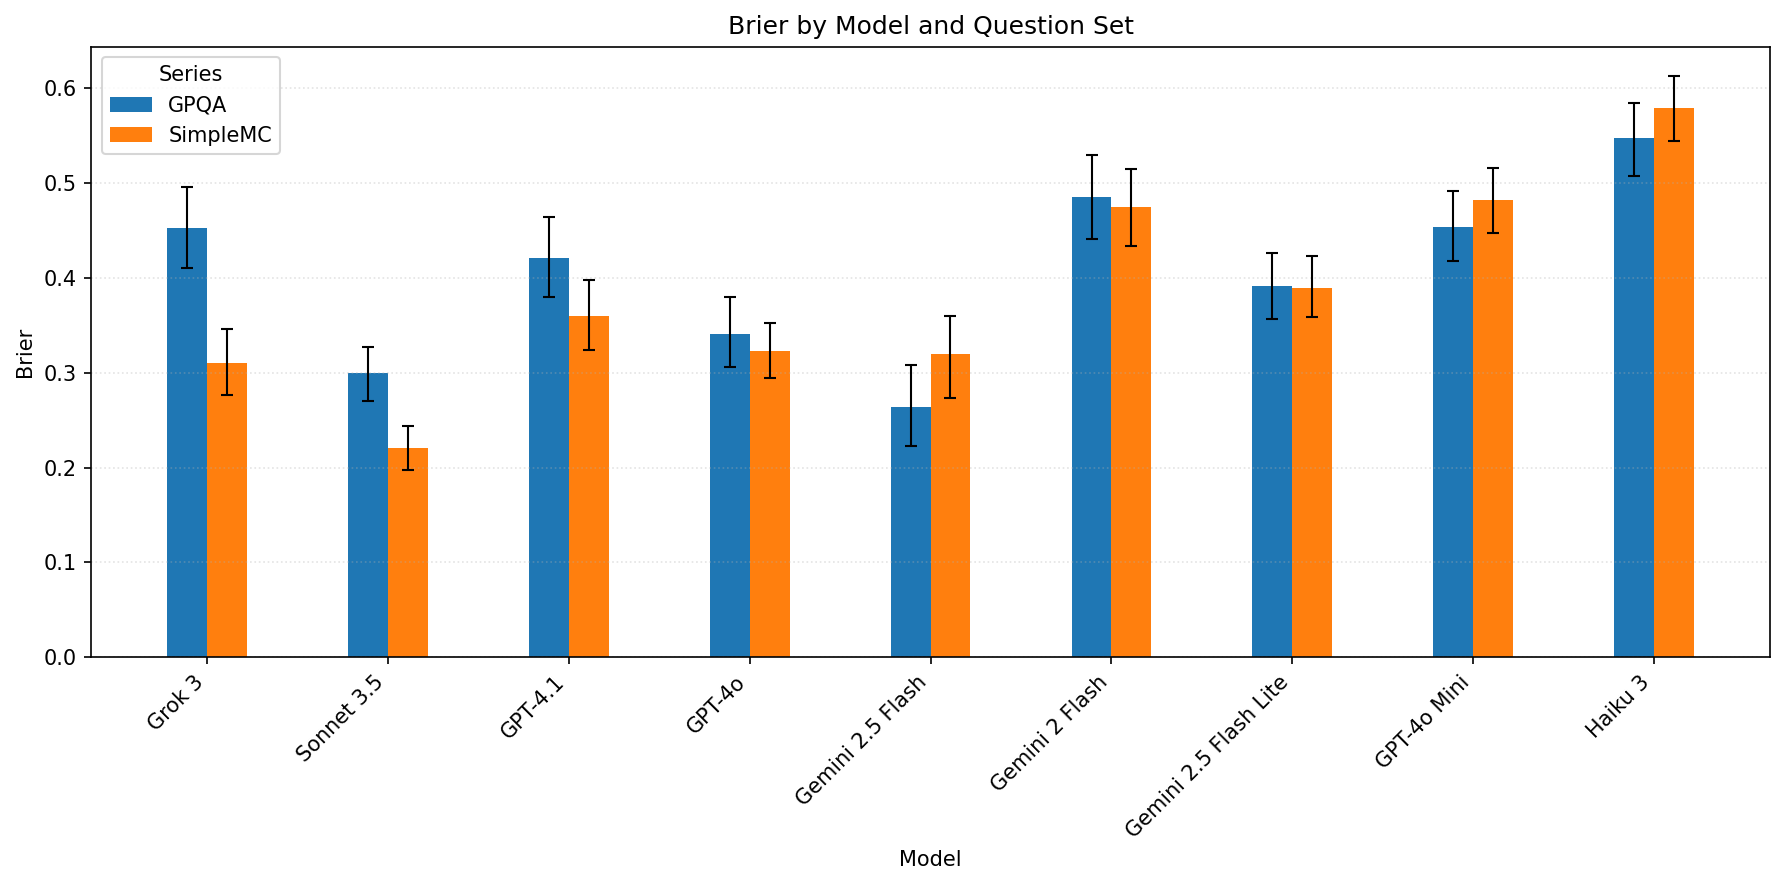

In [47]:
files = ["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt"]#, "analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt"]

metrics = [
    "Delegation rate",
    "Naive Confidence",
    "Teammate-weighted confidence",
    "Raw introspection score",
    "Raw self-acc lift",
    "Correctness Coef Cntl",
    "Pseudo R2 Cntl",                # no CIs -> paired t
    "Capent Correl Cntl",            # treated as correlation (Fisher z)
    "Capent Correl Prob Cntl",       # treated as correlation (Fisher z)
    "Calibration AUC",
    "Calibration Entropy AUC",
    "ECE",
    "Brier",
    "Brier Resolution",
    "Brier Reliability",
    "Top Prob Mean",
]
chance = None#0.5
model_order=["openai-gpt-5-chat", "claude-opus-4-1-20250805", 'claude-sonnet-4-20250514', 'grok-3-latest', 'claude-3-5-sonnet-20241022', 'gpt-4.1-2025-04-14', 'gpt-4o-2024-08-06', 'deepseek-chat', "gemini-2.5-flash", 'gemini-2.0-flash-001', "gemini-2.5-flash-lite", 'gpt-4o-mini', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307', 'gemini-1.5-pro']

model_aliases = {
    "openai-gpt-5-chat": "GPT-5",
    "claude-opus-4-1-20250805": "Opus 4.1",
    'claude-sonnet-4-20250514': "Sonnet 4",
    'grok-3-latest': "Grok 3",
    'claude-3-5-sonnet-20241022': "Sonnet 3.5",
    'gpt-4.1-2025-04-14': "GPT-4.1",
    'gpt-4o-2024-08-06': "GPT-4o",
    'deepseek-chat': "DeepSeek Chat",
    "gemini-2.5-flash": "Gemini 2.5 Flash",
    'gemini-2.0-flash-001': "Gemini 2 Flash",
    "gemini-2.5-flash-lite": "Gemini 2.5 Flash Lite",
    'gpt-4o-mini': "GPT-4o Mini",
    'claude-3-sonnet-20240229': "Sonnet 3",
    'claude-3-haiku-20240307': "Haiku 3",
    'gemini-1.5-pro': "Gemini 1.5 Pro",
}
fig, ax, df_wide = plot_metric_bars(
    metric="Brier",
    files=files,
    series_names=["GPQA", "SimpleMC"],#, "GPSA", "SimpleQA"],
    model_order=model_order,
    aliases=model_aliases,
    title="Brier by Model and Question Set",
    ylabel="",
    outfile="brier_by_model.png"
    , ecolor="black", alpha_err=1.0, chance=chance
)

In [104]:
import os
from typing import List, Optional, Dict, Tuple
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

# Assumes parse_results_file(path) exists in scope

def plot_metric_panels_from_results(
    metric: str,
    files: List[str],
    series_names: Optional[List[str]] = None,  # panel titles
    model_order: Optional[List[str]] = None,
    aliases: Optional[Dict[str, str]] = None,
    suptitle: Optional[str] = None,
    outfile: Optional[str] = None,
    dpi: int = 150,
    # Error bars
    show_errorbars: bool = True,
    ecolor: str = "gray",
    alpha_err: float = 1.0,
    elinewidth: float = 1.0,
    capsize: float = 3.0,
    # Panel behavior
    chance: Optional[float] = None,
    sharey: bool = True,
    consistent_models: bool = False,  # if True, only keep models present in ALL files
    bar_color: Optional[str] = None,  # uniform color for bars; None -> default cycle
    annotate: bool = True,            # write values inside bars
    value_fmt: str = "{:.2f}",        # format for values
    label_color: str = "black",
    label_fontsize: int = 5,
    metric_label=None,            # y-axis label (default: metric name)
) -> Tuple[plt.Figure, np.ndarray, List[pd.DataFrame]]:
    """
    Plot each results file in its own panel (2 files -> 1x2, 4 files -> 2x2).
    Uses parse_results_file exactly as-is.
    Returns (fig, axes_flat, list_of_value_dfs).
    """
    n = len(files)
    if n not in (2, 4):
        raise ValueError("This helper expects 2 or 4 files.")
    if series_names is None:
        series_names = [os.path.basename(f) for f in files]
    if len(series_names) != n:
        raise ValueError("series_names length must match files length")

    # Parse all files
    parsed = [parse_results_file(f) for f in files]

    # Collect model sets
    model_sets = [set(d.keys()) for d in parsed]
    if model_order:
        base_models = [m for m in model_order if all((not consistent_models) or (m in s) for s in model_sets)]
        if not consistent_models:
            # include additional models from any file (but model_order first)
            union_rest = sorted(set().union(*model_sets) - set(base_models))
            base_models = base_models + union_rest
    else:
        base_models = sorted(set.intersection(*model_sets)) if consistent_models else sorted(set().union(*model_sets))

    # Layout
    if n == 2:
        nrows, ncols = 1, 2
        figsize = (12, 4.8)
    else:  # n == 4
        nrows, ncols = 2, 2
        figsize = (12, 9)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi, sharey=sharey)
    axes = np.array(axes).reshape(-1)  # flatten

    wide_vals_list: List[pd.DataFrame] = []
    all_ylim_candidates = []

    # Helper: find metric entry with case-insensitive fallback
    def get_entry(mm: Dict[str, Dict[str, float]], name: str):
        if name in mm:
            return mm[name]
        lm = {k.lower(): k for k in mm}
        k = lm.get(name.lower())
        return mm.get(k) if k else None

    for ax, f, title, data in zip(axes, files, series_names, parsed):
        # Build per-panel table
        models_panel = []
        vals = []
        lo_list = []
        hi_list = []

        # Respect base_models ordering; skip models missing this metric
        for m in base_models:
            entry = get_entry(data.get(m, {}), metric)
            if entry is None or entry.get("value") is None:
                continue
            v = entry.get("value", np.nan)
            lo = entry.get("lo", np.nan)
            hi = entry.get("hi", np.nan)
            models_panel.append(m)
            vals.append(v)
            lo_list.append(lo)
            hi_list.append(hi)

        # If nothing to plot, leave empty panel with a note
        if not models_panel:
            ax.text(0.5, 0.5, "No data for this metric", ha="center", va="center", fontsize=10, alpha=0.7)
            ax.set_title(title)
            ax.set_xlabel("Model")
            ax.set_ylabel(metric_label or metric)
            ax.grid(axis="y", linestyle=":", alpha=0.35)
            continue

        # DataFrame for this panel (for return/debug)
        wide = pd.DataFrame(
            {"value": vals, "lo": lo_list, "hi": hi_list},
            index=models_panel,
        )
        wide_vals_list.append(wide)

        # X/ticks
        x = np.arange(len(models_panel))
        width = 0.6
        ticklabels = [aliases.get(m, m) for m in models_panel] if aliases else models_panel

        # Error bars
        kwargs = {}
        if show_errorbars:
            v = np.asarray(vals, dtype=float)
            lo = np.asarray(lo_list, dtype=float)
            hi = np.asarray(hi_list, dtype=float)
            lower = v - lo
            upper = hi - v
            invalid = np.isnan(lower) | np.isnan(upper) | (lower < 0) | (upper < 0)
            lower = np.where(invalid, np.nan, lower)
            upper = np.where(invalid, np.nan, upper)
            yerr = ma.array(np.vstack([lower, upper]), mask=np.isnan(np.vstack([lower, upper])))
            if (~yerr.mask).any():
                kwargs.update(dict(
                    yerr=yerr, capsize=capsize,
                    error_kw=dict(elinewidth=elinewidth, alpha=alpha_err, ecolor=ecolor),
                ))

            # Collect y-limit candidates (values and CIs)
            valid_min = np.nanmin(np.where(np.isnan(lo), v, lo))
            valid_max = np.nanmax(np.where(np.isnan(hi), v, hi))
            all_ylim_candidates.append(valid_min)
            all_ylim_candidates.append(valid_max)
        else:
            all_ylim_candidates.extend([np.nanmin(vals), np.nanmax(vals)])

        # Bars
        #ax.bar(x, vals, width, **kwargs)
        bar_kwargs = dict(**kwargs)
        if bar_color is not None:
            bar_kwargs["color"] = bar_color
        bars = ax.bar(x, vals, width, **bar_kwargs)
        if annotate:
            for rect, v in zip(bars, vals):
                if np.isnan(v):
                    continue
                va = "top" if v >= 0 else "bottom"
                dy = -3 if v >= 0 else 3  # points offset
                ax.annotate(
                    value_fmt.format(v),
                    xy=(rect.get_x() + rect.get_width() / 2, v),
                    xytext=(0, dy),
                    textcoords="offset points",
                    ha="center",
                    va=va,
                    fontsize=label_fontsize,
                    color=label_color,
                    clip_on=True,
                )

        # Chance line (optional)
        if chance is not None:
            ax.axhline(chance, linestyle="--", color="0.4", linewidth=1.2, zorder=0)

        # Labels
        ax.set_xticks(x)
        ax.set_xticklabels(ticklabels, rotation=45, ha="right")
        ax.set_title(title)
        ###ax.set_xlabel("Model")
        ax.set_ylabel(metric_label or metric)
        ax.grid(axis="y", linestyle=":", alpha=0.35)

    # Match y-limits across panels if sharing or if chance line suggests it
    if sharey and len(all_ylim_candidates) > 0:
        ymin = np.nanmin(all_ylim_candidates)
        ymax = np.nanmax(all_ylim_candidates)
        if chance is not None:
            ymin = np.nanmin([ymin, chance])
            ymax = np.nanmax([ymax, chance])
        if np.isfinite(ymin) and np.isfinite(ymax) and ymin != ymax:
            # Add small margin
            pad = 0.04 * (ymax - ymin)
            for ax in axes:
                ax.set_ylim(ymin - pad, ymax + pad)

    if suptitle:
        fig.suptitle(suptitle, y=0.98)
    # Show y-label only on first chart of each row
    for i, ax in enumerate(axes):
        col = i % ncols
        if col != 0:
            ax.set_ylabel("")
            ax.tick_params(axis="y", labelleft=False)  # or: left=False, labelleft=False to hide ticks too
        fig.tight_layout(rect=(0, 0, 1, 0.97))

    if outfile is None:
        safe_metric = "".join(ch if ch.isalnum() or ch in ("_", "-") else "_" for ch in metric)
        outfile = f"{safe_metric}_panels.png"
    fig.savefig(outfile, bbox_inches="tight")
    plt.show()

    return fig, axes, wide_vals_list

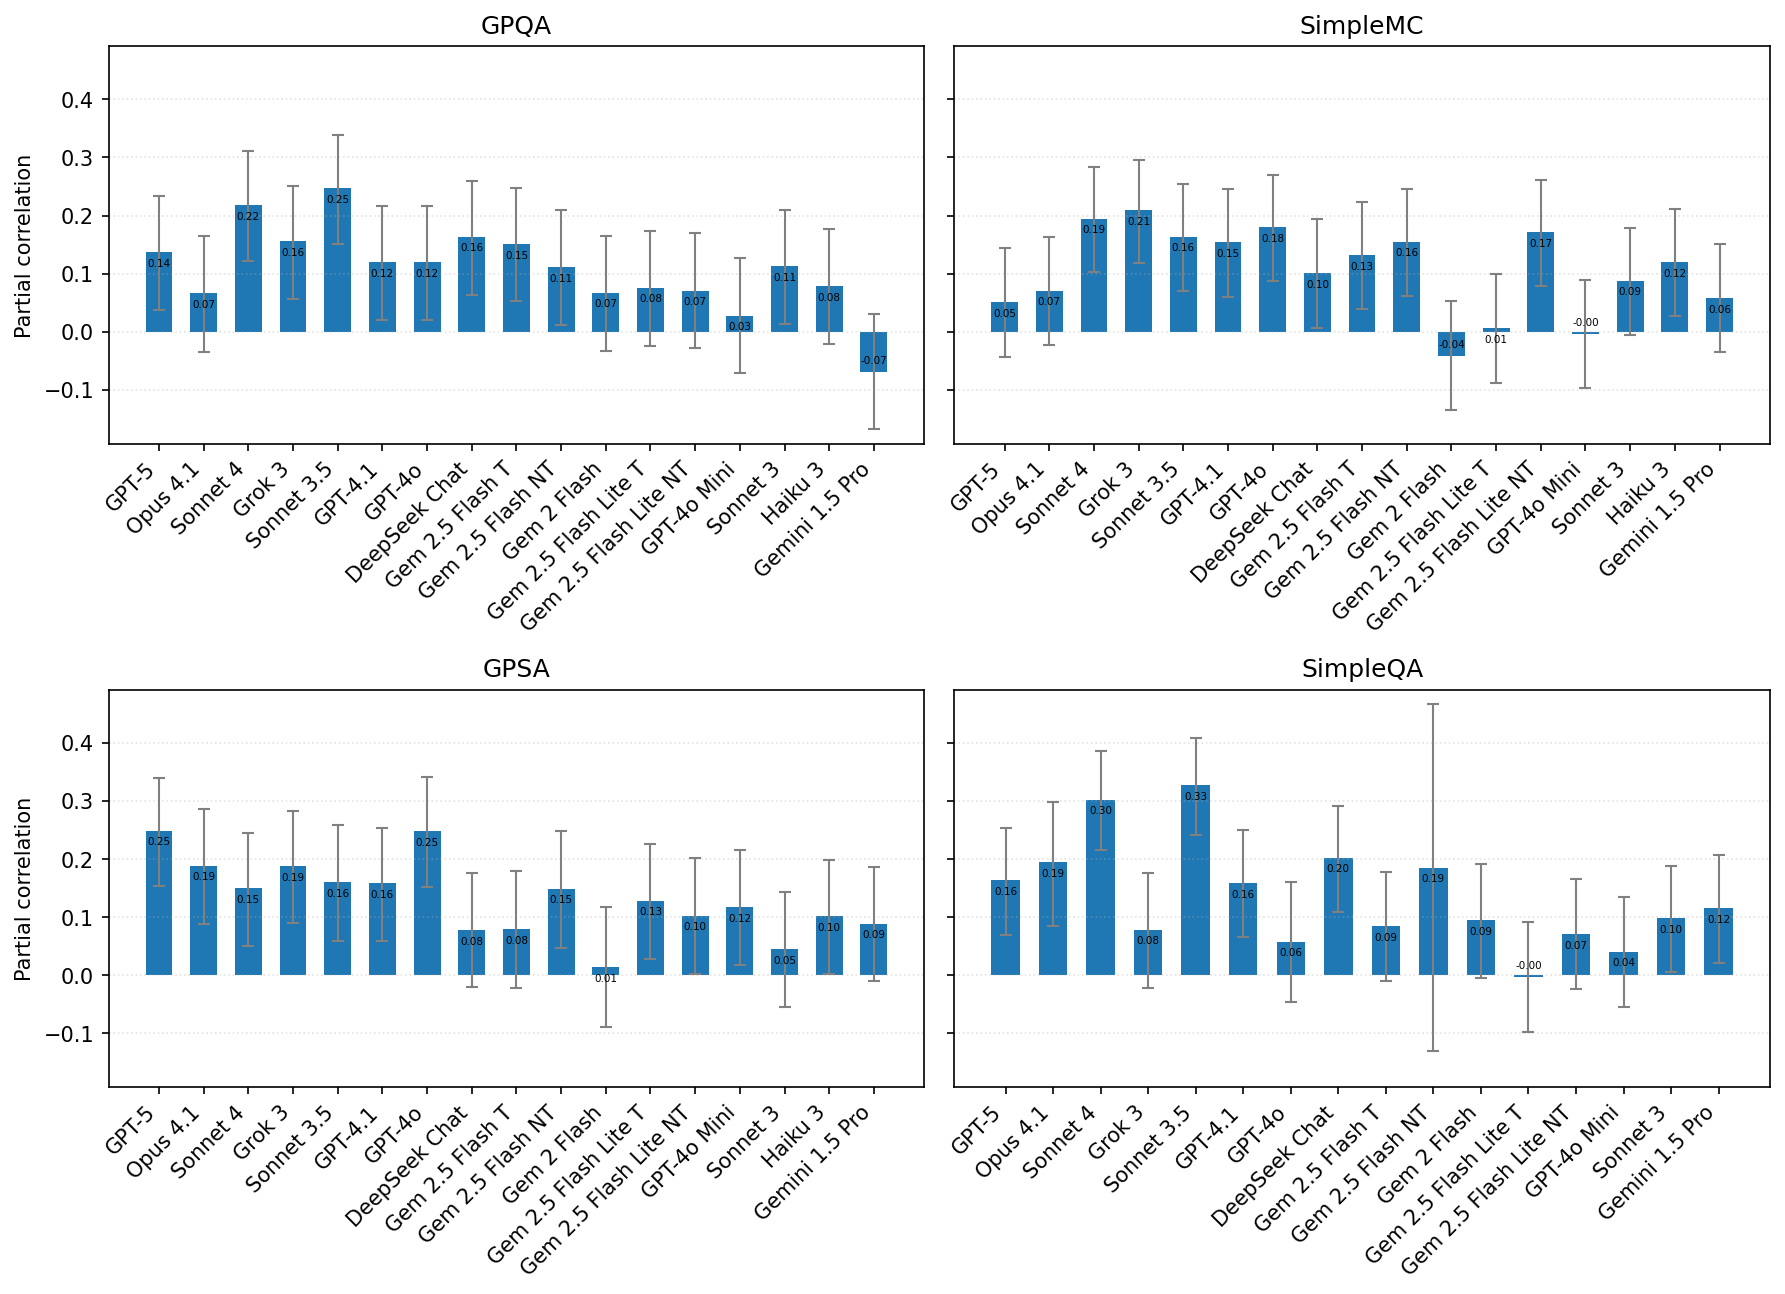

In [105]:
files = ["analysis_log_multi_logres_dg_gpqa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simplemc_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_gpsa_dg_full_hist_parsed.txt", "analysis_log_multi_logres_dg_simpleqa_dg_full_hist_parsed.txt"]
metrics = [
    "Delegation rate",
    "Naive Confidence",
    "Teammate-weighted confidence",
    "Raw introspection score",
    "Raw self-acc lift",
    "Correctness Coef Cntl",
    "Pseudo R2 Cntl",                # no CIs -> paired t
    "Capent Correl Cntl",            # treated as correlation (Fisher z)
    "Capent Correl Prob Cntl",       # treated as correlation (Fisher z)
    "Calibration AUC",
    "Calibration Entropy AUC",
    "ECE",
    "Brier",
    "Brier Resolution",
    "Brier Reliability",
    "Top Prob Mean",
    "Game-Stated Entropy Diff",
]
chance = None#0.5
model_order=["openai-gpt-5-chat", "claude-opus-4-1-20250805", 'claude-sonnet-4-20250514', 'grok-3-latest', 'claude-3-5-sonnet-20241022', 'gpt-4.1-2025-04-14', 'gpt-4o-2024-08-06', 'deepseek-chat', "gemini-2.5-flash_think", "gemini-2.5-flash_nothink", 'gemini-2.0-flash-001', "gemini-2.5-flash-lite_think", "gemini-2.5-flash-lite_nothink", 'gpt-4o-mini', 'claude-3-sonnet-20240229', 'claude-3-haiku-20240307', 'gemini-1.5-pro']

model_aliases = {
    "openai-gpt-5-chat": "GPT-5",
    "claude-opus-4-1-20250805": "Opus 4.1",
    'claude-sonnet-4-20250514': "Sonnet 4",
    'grok-3-latest': "Grok 3",
    'claude-3-5-sonnet-20241022': "Sonnet 3.5",
    'gpt-4.1-2025-04-14': "GPT-4.1",
    'gpt-4o-2024-08-06': "GPT-4o",
    'deepseek-chat': "DeepSeek Chat",
    "gemini-2.5-flash_think": "Gem 2.5 Flash T",
    "gemini-2.5-flash_nothink": "Gem 2.5 Flash NT",
    'gemini-2.0-flash-001': "Gem 2 Flash",
    "gemini-2.5-flash-lite_think": "Gem 2.5 Flash Lite T",
    "gemini-2.5-flash-lite_nothink": "Gem 2.5 Flash Lite NT",
    'gpt-4o-mini': "GPT-4o Mini",
    'claude-3-sonnet-20240229': "Sonnet 3",
    'claude-3-haiku-20240307': "Haiku 3",
    'gemini-1.5-pro': "Gemini 1.5 Pro",
}
fig, ax, df_wide = plot_metric_panels_from_results(
    metric="Correctness Correl Cntl",
    files=files,
    series_names=["GPQA", "SimpleMC", "GPSA", "SimpleQA"],
    model_order=model_order,
    aliases=model_aliases,
    suptitle="",#"Partial correlation between baseline correctness and answer/delegate decision",
    outfile="is_pc_by_model.png"
    , ecolor="gray", alpha_err=1.0, chance=chance, metric_label="Partial correlation"
)

